# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
mouseline = 'sst'  # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
rel_std_bounds = None  # critical relative variation factor determining valid range boundaries
ykeys_plt = [  # Plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False
plot_traces = False

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 02/02/2023 16:38:14: assembling batch analysis settings...
 02/02/2023 16:38:14: sst main analysis notebook started on 2023-02-02 at 16:38:14


### Input summary table figure

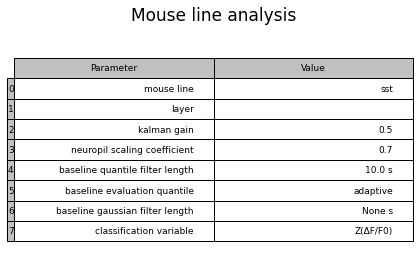

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification
    }, title='Mouse line analysis', aspect=1.5)

### Load data

In [6]:
# Determine exclude patterns
exclude_patterns = {
    'line3': [
        # Yi
        '20191107_mouse1_region2',  # poor cell distribution & segmentation results
        '20191107_mouse1_region1',  # almost zero positive responder
        '20191113_mouse9_region1',  # presence of many dead cells?
        '20191113_mouse9_region2',  # presence of many dead cells?
        '20190829_mouse10_region1',  # almost zero positive responder
        # Celia
        '20191022_mouse1_region1',  # almost zero positive responder
        '20191023_mouse3_region1',  # only 3 conditions, suspicious cell distribution
    ],
    'sarah_line3': [
        
    ],
    'sst': [
        # '20190511_mouse7_region1',  # huge dFF values at .8MPa 50%DC
        # '20190513_mouse2_region1',  # huge dFF values across all DCs at .8MPa
        '20190516_mouse8_region1',  # almost zero positive responder
        '20190516_mouse8_region2',  # almost zero positive responder
        '20190706_mouse7_region1',  # huge peak at 0.1MPa
        '20190808_mouse6_region1',  # huge motion artefacts in initial run 
    ],
    'pv': [
        # '20190606_mouse2_region1',  # incomplete (no high DC data)
        # '20190606_mouse2_region2',  # incomplete (no high DC data), negative dips for positive responders
        # '20190821_mouse3_region1',  # noisy DC dependencies
        # # '20190702_mouse5_region1',  # super negative dip for P = 0.4 MPa
        # # '20190821_mouse6_region1',  # strong activations for low pressures, very noisy dFF profiles
        # # '20190630_mouse3_region1',  # super strong outlier at P = 0.4 MPa
        # # '20190821_mouse7_region1',  # super oscillatory profile
    ]
}[mouseline]

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(stats)

 02/02/2023 16:38:14: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/sst:
 02/02/2023 16:38:14: excluding datasets with the following patterns:
 - 20190516_mouse8_region1
 - 20190516_mouse8_region2
 - 20190706_mouse7_region1
 - 20190808_mouse6_region1
 02/02/2023 16:38:14: loading trial-averaged data from 20190510_mouse6_region1.h5
 02/02/2023 16:38:14: loading trial-averaged data from 20190510_mouse6_region2.h5
 02/02/2023 16:38:15: loading trial-averaged data from 20190511_mouse7_region1.h5
 02/02/2023 16:38:15: loading trial-averaged data from 20190511_mouse7_region2.h5
 02/02/2023 16:38:15: loading trial-averaged data from 20190513_mouse2_region1.h5
 02/02/2023 16:38:15: loading trial-averaged data from 20190513_mouse2_region2.h5
 02/02/2023 16:38:15: loading trial-averaged data from 20190514_mouse1_region1.h5
 02/02

run,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
P (MPa),0.00,0.05,0.10,0.20,0.40,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80
DC (%),50,50,50,50,50,50,05,10,20,30,40,50,60,70,80
dataset,,,,,,,,,,,,,,,
20190510_mouse6_region1,275,nan,nan,273,273,275,274,274,274,274,273,272,nan,nan,nan
20190510_mouse6_region2,292,nan,nan,292,290,289,291,290,291,290,289,290,nan,nan,nan
20190511_mouse7_region1,363,nan,nan,364,363,362,365,364,365,362,363,360,nan,nan,nan
20190511_mouse7_region2,390,nan,nan,389,388,387,392,393,393,393,393,393,nan,nan,nan
20190513_mouse2_region1,300,nan,nan,310,302,304,282,268,250,287,268,249,nan,nan,nan
20190513_mouse2_region2,347,nan,nan,365,365,359,362,350,355,357,318,360,nan,nan,nan
20190514_mouse1_region1,296,nan,nan,297,295,298,297,297,297,295,296,295,nan,nan,nan


### Breakdown per mouse region & cell maps

 02/02/2023 16:38:26: identified 51.9% of responders with 0.33 as threshold proportion of responding conditions
 02/02/2023 16:38:26: plotting cell maps...


100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


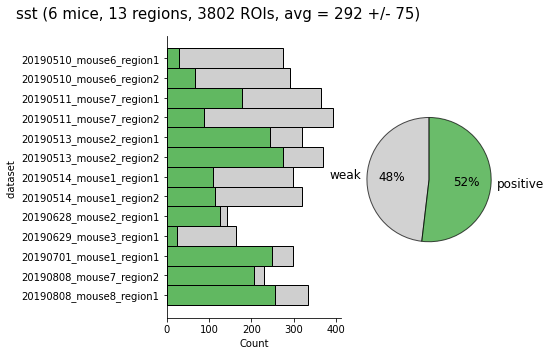

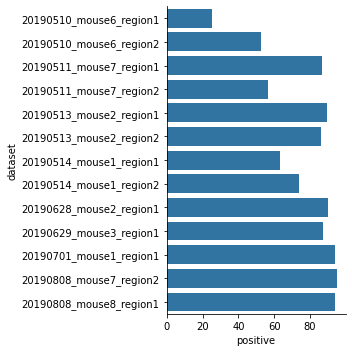

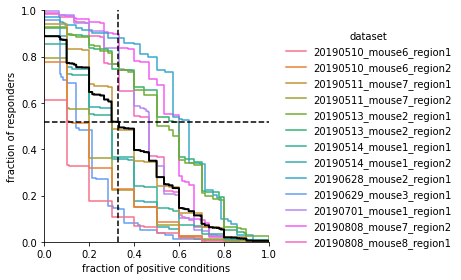

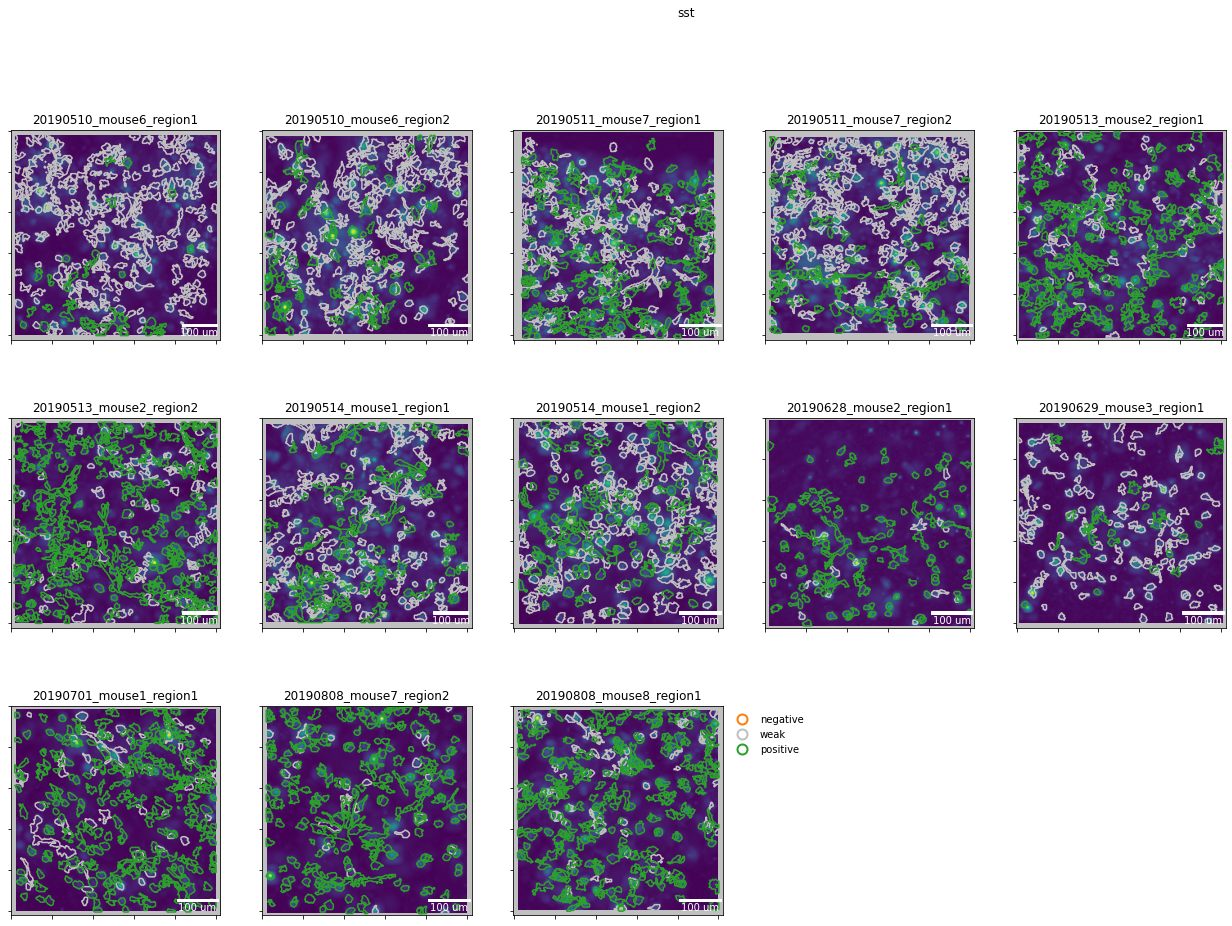

In [7]:
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0) * 100
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

### Inspect run sequences per dataset and potential consequences on evoked activity

 02/02/2023 16:38:40: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 02/02/2023 16:38:40: run ID no part of (P (MPa), DC (%)) -> no filtering
 02/02/2023 16:38:40: sub-indexing data...
 02/02/2023 16:38:40: filtering data...
 02/02/2023 16:38:40: cross-checking filters...
 02/02/2023 16:38:40: grouping by dataset, averaging, estimating confidence intervals and plotting mean I_SPTA (W/cm2) vs. run ID ...
 02/02/2023 16:38:43: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 02/02/2023 16:38:43: run ID no part of (P (MPa), DC (%)) -> no filtering
 02/02/2023 16:38:43: sub-indexing data...
 02/02/2023 16:38:43: filtering data...
 02/02/2023 16:38:43: cross-checking filters...
 02/02/2023 16:38:43: grouping by dataset, averaging, estimating confidence intervals and plotting mean evoked ΔF/F0 change vs. run ID ...
 02/02/2023 16:38:46: parameter sequences across datasets:


dataset,20190510_mouse6_region1,20190510_mouse6_region2,20190511_mouse7_region1,20190511_mouse7_region2,20190513_mouse2_region1,20190513_mouse2_region2,20190514_mouse1_region1,20190514_mouse1_region2,20190628_mouse2_region1,20190629_mouse3_region1,20190701_mouse1_region1,20190808_mouse7_region2,20190808_mouse8_region1
run ID,,,,,,,,,,,,,
0,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC
1,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC
2,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC
3,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC
4,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC
5,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC
6,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC
7,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC
8,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.20MPa_50%DC,0.20MPa_50%DC


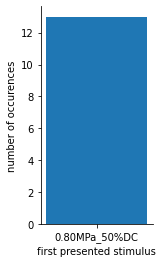

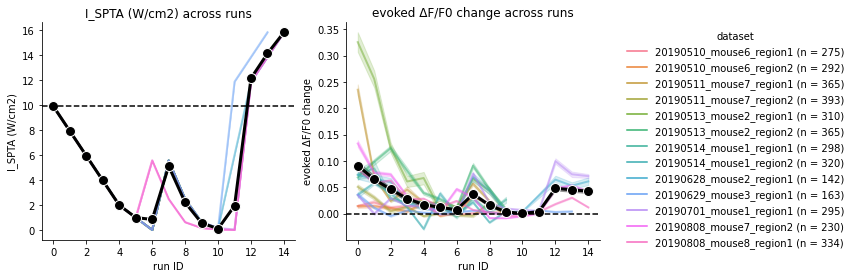

In [8]:
# Get parameter run sequence per dataset
param_seqs = stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot distribution of first persented stimulus
first_stims_dist = param_seqs.loc[0, :].value_counts()
figs['first stimulus distribution'], ax = plt.subplots(figsize=(2 * len(first_stims_dist), 4))
ax.set_xlabel('first presented stimulus')
ax.set_ylabel('number of occurences')
sns.despine(ax=ax)
ax.bar(first_stims_dist.index, first_stims_dist.values)

# Plot Ispta and evoked DFF across run sequences, per dataset
ykeys_seq = [Label.ISPTA, get_change_key(Label.DFF)]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(
    1, len(ykeys_seq), figsize=(5 * len(ykeys_seq), 4))
axes = np.atleast_1d(axes)
for i, (ykey, ax) in enumerate(zip(ykeys_seq, axes)):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        stats, xkey=Label.RUNID, ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, avgprop='whue', errprop='intra', ax=ax,
        legend=i == len(ykeys_seq) - 1, title=f'{ykey} across runs')

logger.info('parameter sequences across datasets:')
param_seqs

### Plot evoked change distribution for control condition (P = 0)

 02/02/2023 16:38:47: response type proportions at P = 0:
weak        90.662731
positive     9.337269
Name: response type, dtype: float64


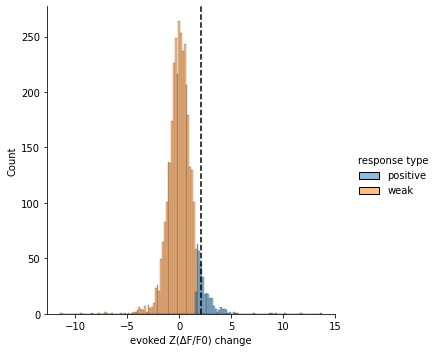

In [9]:
stats0 = stats[stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

fg = sns.displot(
    kind='hist',
    data=stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
)
fig = fg.figure
ax = fig.axes[0]
ax.axvline(stats0[ykeydiff].quantile(.95), c='k', ls='--')

props0 = stats0[Label.RESP_TYPE].value_counts() / len(stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Plot proportion of responders vs input parameters 

 02/02/2023 16:38:47: I_SPTA (W/cm2) no part of (P (MPa), DC (%)) -> no filtering


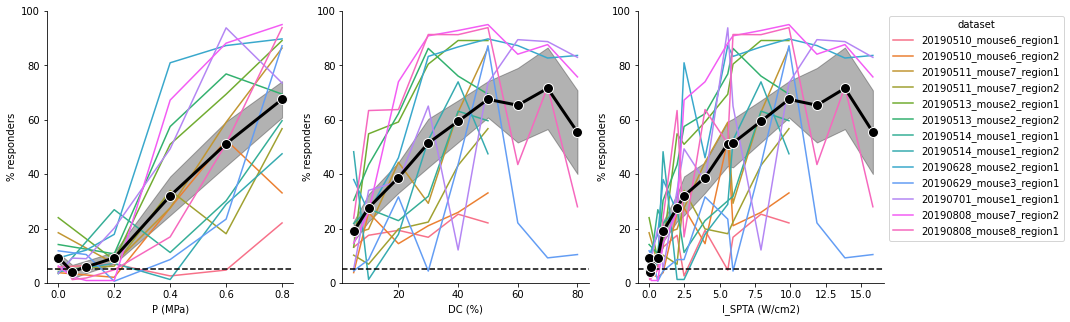

In [10]:
xkeys = [Label.P, Label.DC, Label.ISPTA]
figs[f'respprop vs stimparams'], axes = plt.subplots(
    1, len(xkeys), figsize=(5 * len(xkeys), 5))
for i, (xkey, ax) in enumerate(zip(xkeys, axes)):
    plot_pct_responders(
        stats, xkey,
        kind='line',
        hue=Label.DATASET,
        ax=ax,
        legend='full' if i == len(xkeys) - 1 else False,
        # hue_highlight='20190808_mouse7_region2'
        # hue_width=True
    )
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

### Plot pressure and DC dependency curves

 02/02/2023 16:38:47: plotting ΔF/F0 stimulation parameters dependencies across responders...
 02/02/2023 16:38:47: sub-indexing data...
 02/02/2023 16:38:47: filtering data...
 02/02/2023 16:38:48: cross-checking filters...
 02/02/2023 16:38:48: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 02/02/2023 16:38:48: sub-indexing data...
 02/02/2023 16:38:48: filtering data...
 02/02/2023 16:38:48: cross-checking filters...
 02/02/2023 16:38:48: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 02/02/2023 16:38:48: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 02/02/2023 16:38:48: I_SPTA (W/cm2) no part of (P (MPa), DC (%)) -> no filtering
 02/02/2023 16:38:48: sub-indexing data...
 02/02/2023 16:38:48: filtering data...
 02/02/2023 16:38:48: cross-checking filters...
 02/02/2023 16:38:48: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. I_SPTA (W/cm2) ...
 02/02/2023 16:

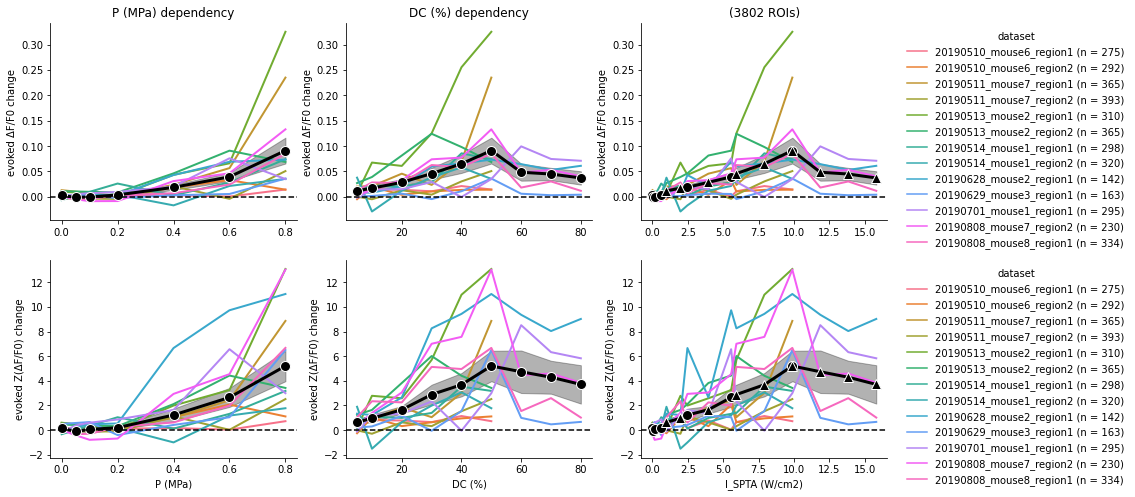

In [11]:
xkeys = [Label.P, Label.DC, Label.ISPTA]
figs['stimparamdeps_global'], axes = plt.subplots(
    len(ykeys_plt), len(xkeys), figsize=(5 * len(xkeys), len(ykeys_plt) * 4))
axes = np.atleast_2d(axes)
fit = False
for ykey, axrow in zip(ykeys_plt, axes):
    # Determine output metrics key
    ykey_diff = get_change_key(ykey)

    # # Plot param dependencies across datasets for each responder type separately
    # tmpaxes = []
    # for rtype, substats in stats.groupby(Label.ROI_RESP_TYPE):
    #     figkey = f'{ykey}_stimparamdeps_{rtype}'
    #     logger.info(f'plotting {ykey} stimulation parameters dependencies for {rtype} responders...')
    #     logger.setLevel(logging.WARNING)
    #     figs[figkey] = plot_stimparams_dependency(
    #         substats, ykey_diff, yref=0, hue=Label.DATASET, 
    #         avgprop='whue', errprop='inter',
    #         hue_alpha=1.,
    #         lw=0,
    #         ci=None,
    #         fit=fit, 
    #     )
    #     figs[figkey].suptitle(f'{mouseline} - {rtype} responders')
    #     tmpaxes = tmpaxes + figs[figkey].axes
    #     logger.setLevel(logging.INFO)
    # harmonize_axes_limits(np.asarray(tmpaxes))

    # Plot dependencies on each parameter on separate axes
    logger.info(f'plotting {ykey} stimulation parameters dependencies across responders...')
    # plot_stimparams_dependency(
    #     stats[stats[Label.ROI_RESP_TYPE] =='positive'], 
    #     ykey=ykey_diff, yref=0., 
    #     hue=Label.ROI_RESP_TYPE, 
    #     axes=axrow,
    #     weighted=True,
    #     fit=fit,
    # )
    plot_stimparams_dependency(
        stats, 
        ykey=ykey_diff, yref=0., 
        hue=Label.DATASET, hue_alpha=1.,
        avgprop='whue', 
        errprop='inter',
        err_style='band',
        axes=axrow,
        fit=fit,
        ci=None,
        xkeys=xkeys
    )
for axrow in axes[1:]:
    for ax in axrow:
        ax.set_title(None)
for axrow in axes[:-1]:
    for ax in axrow:
        ax.set_xlabel(None)

### Plot trial heatmap per condition for entire mouse line

In [12]:
%%skip $skip_rasters

# # Get proportion of each response type per condition and dataset
# respcounts = stats[Label.RESP_TYPE].groupby([Label.DATASET, Label.RUN]).value_counts()
# totcounts = respcounts.groupby([Label.DATASET, Label.RUN]).sum()
# respprops = respcounts / totcounts
# respprops = respprops.unstack().fillna(0)
# # Get datasets & conditions yelding high proportions of positive and negative responders
# negresps = respprops[respprops['negative'] >= 0.5]['negative'].sort_values(ascending=False).to_frame()
# negresps['color'] = Palette.RTYPE['negative']
# posresps = respprops[respprops['positive'] >=0.5]['positive'].sort_values(ascending=False).to_frame()
# posresps['color'] = Palette.RTYPE['positive']
# extreme_conds = pd.concat([negresps, posresps], axis=0)
# rect_markers = extreme_conds['color']
rect_markers = None

sorted_ISPTAs = stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(stats, Label.FPS)
for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_trial_heatmap(
        timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
        rect_markers=rect_markers
    )

### Plot response traces

In [13]:
%%skip $skip_traces

# Get plot-ready traces dataset
plt_data = get_plot_data(timeseries, stats)

# Align DFF and z-score traces w.r.t their pre-stimulus average
plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
    plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.PRESTIM)

# Get onset slice
mux_slice = slice_last_dim(plt_data.index, FrameIndex.STIM)

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None # Label.ROI_RESP_TYPE

# For each output variable
for ykey in ykeys_plt:

    # Pressure-dependent and dutcy cycle dependent response traces, per dataset
    for pkey in pkeys:
        figs.update(
            plot_responses_across_datasets(
                plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []  
    for pkey in pkeys:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True, groupby=groupby)
        avgaxes = avgaxes + figs[f'{ykey} vs. {pkey} by type'].axes
    harmonize_axes_limits(avgaxes)

### Save responder-type-averaged stats to disk

In [14]:
rtypeavg_dir = get_output_equivalent(
    os.path.split(trialavg_dir)[0], 'trial-averaged', 'rtype-averaged')
fpath = os.path.join(rtypeavg_dir, f'{mouseline}.csv')
stats_per_rtype = get_crossdataset_average(stats, Label.RUN, hue=Label.ROI_RESP_TYPE)
logger.info(f'saving responder-type-averaged stats to {fpath}...')
stats_per_rtype.to_csv(fpath)

 02/02/2023 16:38:50: saving responder-type-averaged stats to /Users/tlemaire/Documents/data/usnm/rtype-averaged/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/sst.csv...


### Save figures

In [15]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 02/02/2023 16:38:50: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.02.02/figs_main_sst_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


### Notify upon completion

In [16]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 02/02/2023 16:38:53: sst batch notebook completed in 0:00:39.800883 s
